# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas  https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. We will also use Principal Components Analysis (PCA) to reduce its dimensions. 



<div class='exercise'><b> Question 1 [25 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

**1.2** Notice that the resulting training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?  Explain in 3 or fewer sentences.

**1.3** Let's explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

**1.4** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors and different markers ('x' vs 'o', for example). How well do the top two principal components discriminate between the two classes? How much of the variance within the predictor set do these two principal components explain? 

**1.5** Plot the cumulative variance explained in the feature set as a function of the number of PCA-components (up to the first 50 components).  Do you feel 2 components is enough, and if not, how many components would you choose to consider?  Justify your choice in 3 or fewer sentences.  Finally, determine how many components are needed to explain at least 90% of the variability in the feature set. 

#### Answers:
First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [3]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [4]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [5]:
y_train=data_train['Cancer_type']
y_test=data_test['Cancer_type']

**1.1:** Take a peek at your training set...

In [6]:
min_vals = data_train.min()
print(min_vals.shape)
data_train.shape

(7130,)


(40, 7130)

In [7]:
# your code here
data_train.head()
scaler=MinMaxScaler()
scaler.fit(data_train)
data_train_scaled=scaler.transform(data_train)
data_train_scaled=pd.DataFrame(data_train_scaled,index=data_train.index,columns=data_train.columns)
data_test_scaled=scaler.transform(data_test)
data_test_scaled=pd.DataFrame(data_test_scaled,index=data_test.index,columns=data_test.columns)


*your answer here* 


**1.2:** Notice that the resulting training set contains...

In [8]:
# your code here
data_train.shape

(40, 7130)

*your answer here*


In [9]:
'AFFX-PheX-5_at' in data_train.columns

True

**1.3:** Let's explore a few of the genes...

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:

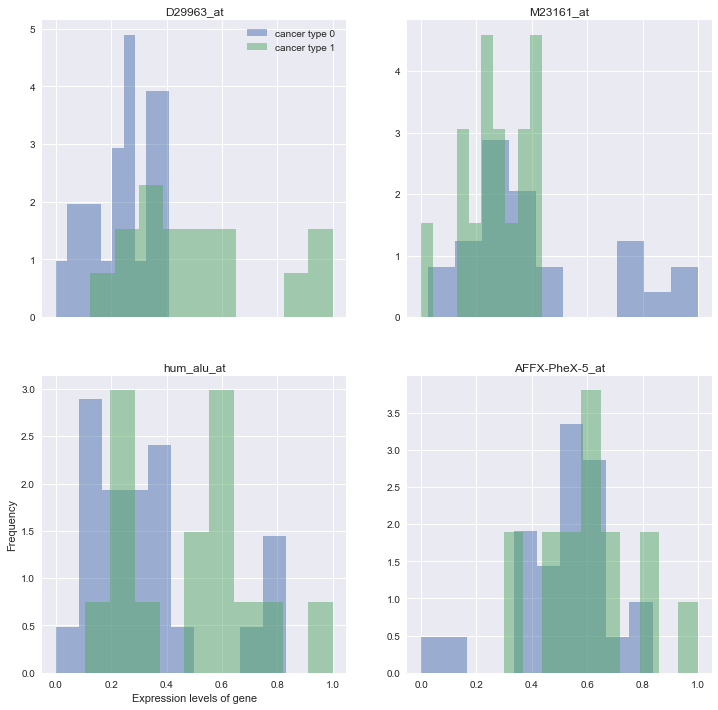

In [10]:
# your code here
alpha=0.5
ALL=data_train_scaled[data_train.Cancer_type==0]
AML=data_train_scaled[data_train.Cancer_type==1]
genes_list=['D29963_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at']
fig,axes=plt.subplots(2,2,sharex=True,figsize=(12, 12))
ax=axes.ravel()
for i in range(4):
    ax[i].hist(ALL[genes_list[i]],alpha=alpha,normed=True)
    ax[i].hist(AML[genes_list[i]],alpha=alpha,normed=True)
    ax[i].set_title(genes_list[i])
ax[2].set_xlabel("Expression levels of gene")
ax[2].set_ylabel("Frequency")
ax[0].legend(['cancer type 0 ','cancer type 1'],loc="best")   
plt.show()

*your answer here*


**1.4:** Since our data has dimensions that are not easily visualizable...

In [11]:
data_train_scaled.shape

(40, 7130)

In [12]:
data_train.Cancer_type.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [13]:
pca=PCA(n_components=2)
X_pca_2=pca.fit_transform(data_train_scaled)


In [14]:
X_pca_2=pd.DataFrame(X_pca_2,columns=['1st component','2nd component'])
X_pca_2['Cancer type']=data_train.Cancer_type.values

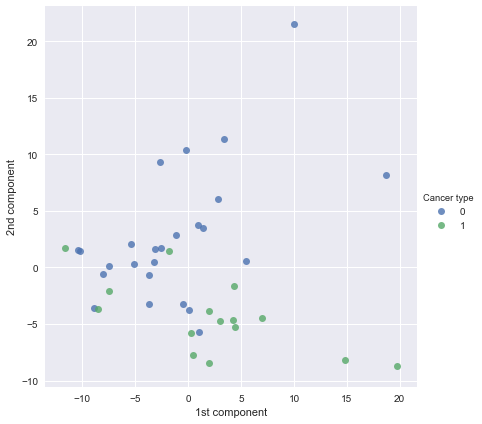

In [15]:
sns.lmplot(x="1st component",y="2nd component",hue="Cancer type",data=X_pca_2,fit_reg=False,size=6)

*your answer here*


**1.5**: Plot the cumulative variance explained in the feature set...

In [16]:
# your code here
pca.explained_variance_ratio_

array([0.15881506, 0.11443613])

Text(0,0.5,'cumulatvie explained variance')

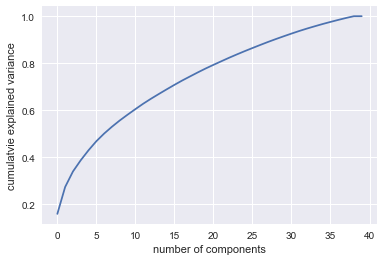

In [17]:
pca=PCA().fit(data_train_scaled)
cumsum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel("number of components")
plt.ylabel('cumulatvie explained variance')

In [18]:
cumsum >0.9

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [19]:
d=np.argmax(cumsum>=0.9)+1
d

29

*your answer here*


<div class='exercise'> <b> Question 2 [25 pts]: Linear Regression vs. Logistic Regression </b> </div>

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at` to predict cancer type and plot the histogram of predicted values. We could interpret the scores predicted by the regression model for a patient as an estimate of the probability that the patient has `Cancer_type`=1 (AML). Is there a problem with this interpretation?

**2.2** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary classes 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy of the obtained classification model on both the training and test sets.

**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? If there are no substantial differences, why do you think this happens? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').  

**2.4** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 




#### Answers: 

**2.1:** Fit a simple linear regression model to the training set

Text(0.5,1,'Output Probability Histogram on Test Data')

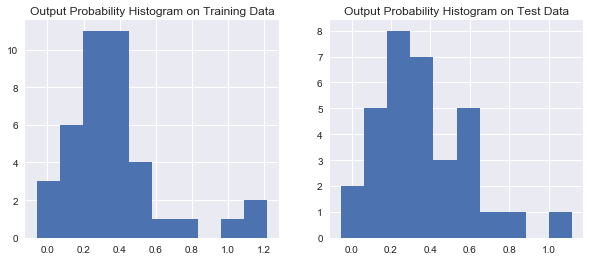

In [20]:
# your code here
single_x_train=data_train_scaled.D29963_at.values.reshape(-1,1)
single_x_test=data_test_scaled.D29963_at.values.reshape(-1,1)
from sklearn.linear_model import LinearRegression
slr=LinearRegression()
slr.fit(single_x_train,y_train)
predicted_y=slr.predict(single_x_train)
predicted_y_test=slr.predict(single_x_test)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(predicted_y)
ax[1].hist(predicted_y_test)
ax[0].set_title("Output Probability Histogram on Training Data")
ax[1].set_title("Output Probability Histogram on Test Data")

*your answer here*


**2.2:** The fitted linear regression model can be converted to a classification model...

In [21]:
pred_train=pd.DataFrame({'prediected_val':predicted_y>=0.5,'true_val':data_train_scaled.Cancer_type})

train_score=accuracy_score(y_train,predicted_y>=0.5)
test_score=accuracy_score(y_test,predicted_y_test>=0.5)
print('train_score:',train_score)
print('test_score:{:.3f}'.format(test_score))


train_score: 0.8
test_score:0.758


*your answer here*


**2.3:** Next, fit a simple logistic regression model to the training set...

In [22]:
# your code here
logreg=LogisticRegression(C=100000)
logreg.fit(single_x_train,y_train)
print('training set score: {:.3f}'.format(logreg.score(single_x_train,y_train)))
print('test set score: {:.3f}'.format(logreg.score(single_x_test,y_test)))


training set score: 0.800
test set score: 0.758


*your answer here*


**2.4:** Create a figure with 4 items ...

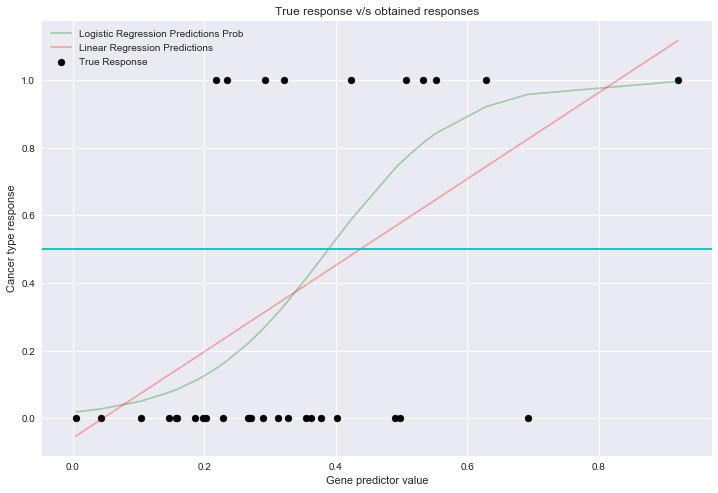

In [23]:
sort_index=np.argsort(data_test_scaled['D29963_at'].values)
plt.figure(figsize=(12,8))
#true response
plt.scatter(data_test_scaled['D29963_at'].iloc[sort_index],data_test_scaled['Cancer_type'].iloc[sort_index],color='black', label = 'True Response')
#fitted logistics model
y_test_pred_logreg_prob=logreg.predict_proba(single_x_test)[:,1]
plt.plot(data_test_scaled['D29963_at'].iloc[sort_index], y_test_pred_logreg_prob[sort_index], alpha=0.3,  \
         color='green', label = 'Logistic Regression Predictions Prob')
#simple regression model
y_test_pred_slr=slr.predict(single_x_test)
plt.plot(data_test_scaled['D29963_at'].iloc[sort_index],y_test_pred_slr[sort_index],color='red', alpha=0.3, \
         label = 'Linear Regression Predictions')

plt.axhline(0.5, c='c')
plt.legend()
plt.title('True response v/s obtained responses')
plt.xlabel('Gene predictor value')
plt.ylabel('Cancer type response');

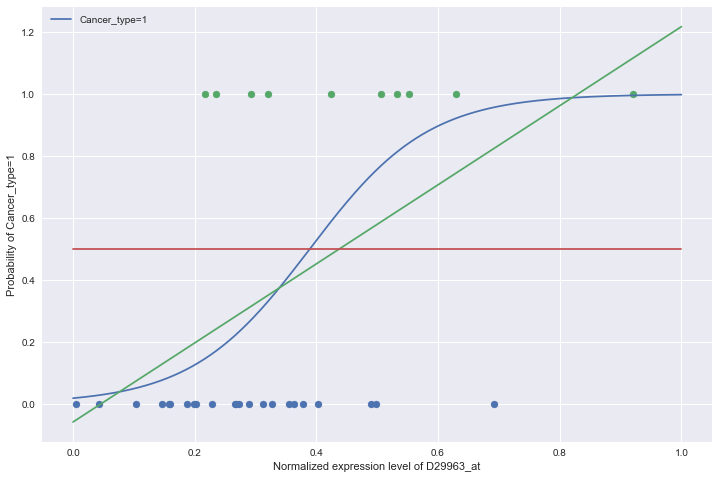

In [24]:
#fitted logistics model
plt.figure(figsize=(12,8))
X_new=np.linspace(0,1,1000).reshape(-1,1)
y_proba=logreg.predict_proba(X_new)
plt.plot(X_new,y_proba[:,1],label='Cancer_type=1')
plt.xlabel('Normalized expression level of D29963_at' )
plt.ylabel('Probability of Cancer_type=1')
plt.legend()

#the true binary response for the test set points for both models in the same plot
cancer0=data_test_scaled[data_test_scaled.Cancer_type==0]
cancer1=data_test_scaled[data_test_scaled.Cancer_type==1]
plt.scatter(cancer0.D29963_at,cancer0.Cancer_type)
plt.scatter(cancer1.D29963_at,cancer1.Cancer_type)

#the quantitative response from the linear regression model as a function of the gene predictor
y_slr=slr.predict(X_new)
plt.plot(X_new,y_slr)

#a horizontal line at  y=0.5
y_new=0.5*np.ones(1000)
plt.plot(X_new,y_new)



*your answer here*


<div class='exercise'> <b> Question 3 [30pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

**3.3** Use the `visualize_prob` function provided below (or any other visualization) to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

**3.4** Open question: Comment on the classification accuracy of the train and test sets. Given the results above how would you assess the generalization capacity of your trained model?  What other tests or approaches would you suggest to better guard against the false sense of security on the accuracy of the model as a whole. 


In [25]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for x
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers:

**3.1:** Next, fit a multiple logistic regression model with all the gene predictors...

In [26]:
X_train=data_train_scaled.drop('Cancer_type',axis=1)
mlogreg=LogisticRegression(C=100000)
mlogreg.fit(X_train,y_train)
print("Train set score:{:.3f}".format(mlogreg.score(X_train,y_train)))
X_test=data_test_scaled.drop('Cancer_type',axis=1)
y_test_pred_logreg=mlogreg.predict(X_test)
print("Test set score:{:.3f}".format(accuracy_score(y_test,y_test_pred_logreg)))


Train set score:1.000
Test set score:1.000


*your answer here*


**3.2:** How many of the coefficients estimated by this multiple logistic regression...

In [27]:
# bootstrapping code
# your code here
mlogreg

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

*your answer here*


**3.3:** Use the visualize_prob function provided below ...

Text(0.5,1,'test set')

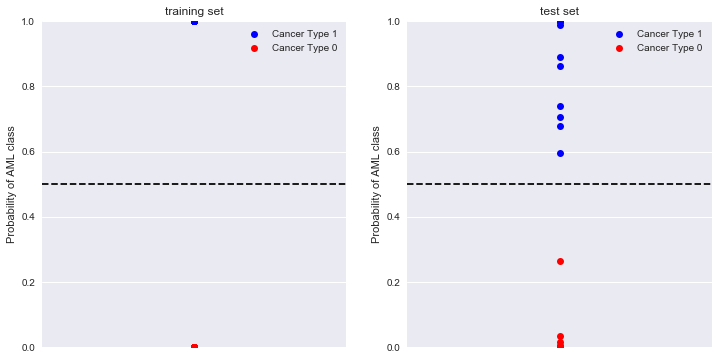

In [28]:
""" Plot classification model """

# your code here
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# visualising train set fit
visualize_prob(mlogreg, X_train, y_train, ax1)
ax1.set_title('training set')

# visualising test set fit
visualize_prob(mlogreg, X_test, y_test, ax2)
ax2.set_title('test set')


*your answer here*


**3.4:** Open question: Comment on the classification accuracy...


*your answer here* 


<div class='exercise'><b> Question 4 [20 pts]: PCR: Principal Components Regression </b></div>

High dimensional problems can lead to problematic behavior in model estimation (and make prediction on a test set worse), thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

**4.1:** Fit two separate Logistic Regression models using principal components as the predictors: (1) with the number of components you selected from problem 1.5 and (2) with the number of components that explain at least 90% of the variability in the feature set. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3?   

**4.2:** Use the code provided in question 3 (or your choice of visualization) to visualize the probabilities predicted by the fitted models in the previous part on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?


#### Answers:

**4.1:** Fit two separate Logistic Regression models...

In [140]:
# your code here


*your answer here*


**4.2:** Use the code provided in question 3...

In [284]:
# your code here


*your answer here*